In [1]:
import pandas as pd
from copy import deepcopy

data = pd.read_csv("./data.csv")
uname = data[:1].get_values()[0]
data.drop(0).head()

,11213962,1603589724,68746721,267765193,10985942,14009672,167346791,2896013873,17364190,31442147,...,118320586,218493756,232520574,385409365,419425806,102227818,301210136,175163526,252996913,152543735
1,False,False,True,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5,False,False,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


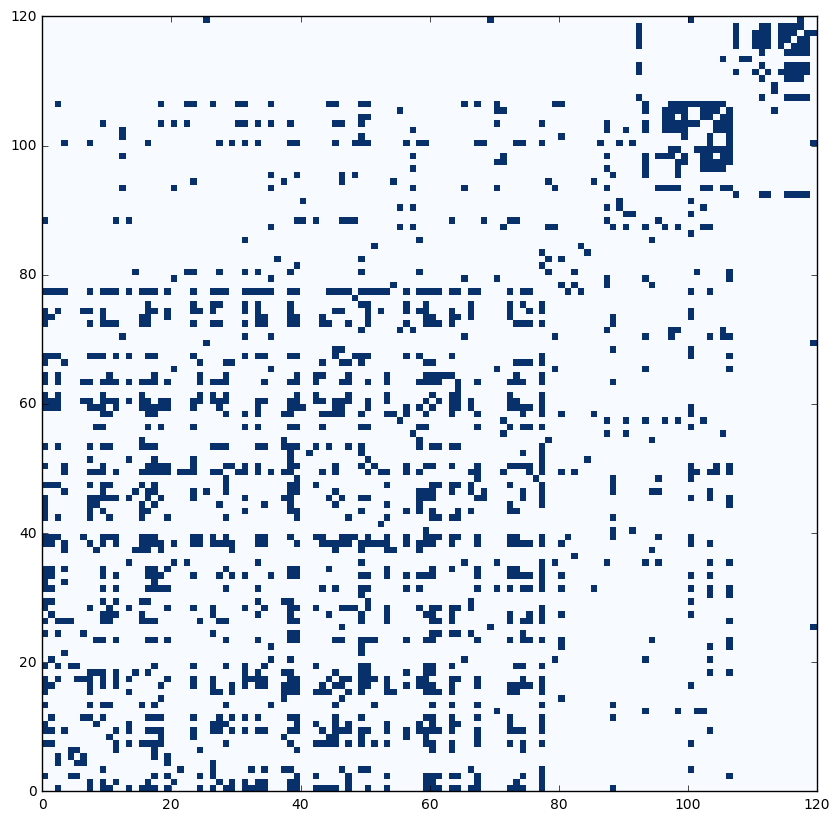

In [2]:
X = (data.get_values()[1:]=="True")
A = (X.T + X)

%matplotlib inline
import pylab as plt
import seaborn as sns
import numpy as np

def plot_matrix(matrix, z1=None):
    f, ax = plt.subplots(figsize=(10, 10))
    plt.pcolor(matrix, cmap=plt.cm.Blues )
    
    if not z1 is None:
        z1_diff = np.r_[[0], np.diff(z1)]

        for i,c in enumerate(z1_diff):
            if c!=0:
                ax.axhline(i, c="grey")#, linewidth=1)
                ax.axvline(i, c="grey") #, linewidth=1)
    plt.show()
plot_matrix(A)

In [3]:
import scipy.linalg
from copy import deepcopy

K = 10
m = 1
hi = K-1
lo = 0
θ = 40
N = A.shape[0]

In [4]:
A = A.astype(int)
D = np.eye(N) * A.sum(axis=0)

In [5]:
Ag = deepcopy(A)

last_trace = 1000000
while True:
    # update H
    L = np.eye(Ag.shape[0]) * Ag.sum(axis=0) - Ag
    λ, H = scipy.linalg.eigh(L,eigvals=(lo,hi))
    trace = np.trace(np.matrix(H).T * np.matrix(Ag) * np.matrix(H)) #<  then break ??
    print(trace)

    if last_trace < trace:
        break
        print(Ag)
    last_trace = trace
    
    Ag = deepcopy(A)
    list_countᵢ = A.sum(axis=0) - m    
    exclude_edge = np.ones(Ag.shape)
    X = []
    pₑ = np.array([[exclude_edge[i,j] * Ag[i,j] * np.dot(H[i] - H[j], H[i] - H[j]) for i in range(N)] for j in range(N)])

    while pₑ.max() > 0:
        pₑ = np.array([[exclude_edge[i,j] * Ag[i,j] * np.dot(H[i] - H[j], H[i] - H[j]) for i in range(N)] for j in range(N)])
        i,j = np.unravel_index(pₑ.argmax(), pₑ.shape)
        #print(pₑ.max())
        #print(list_countᵢ[i], list_countᵢ[j])
        if (list_countᵢ[i]>0) and (list_countᵢ[j]>0):
            X.append((i,j))
            list_countᵢ[i] = -1
            list_countᵢ[j] = -1
            Ag[i,j] = 0
            Ag[j,i] = 0
            #print(X)
            #print(len(X))
            if len(X) > θ:
                break
        else:
            exclude_edge[i,j] = 0
            exclude_edge[j,i] = 0
    

29.8081930161
33.431074866


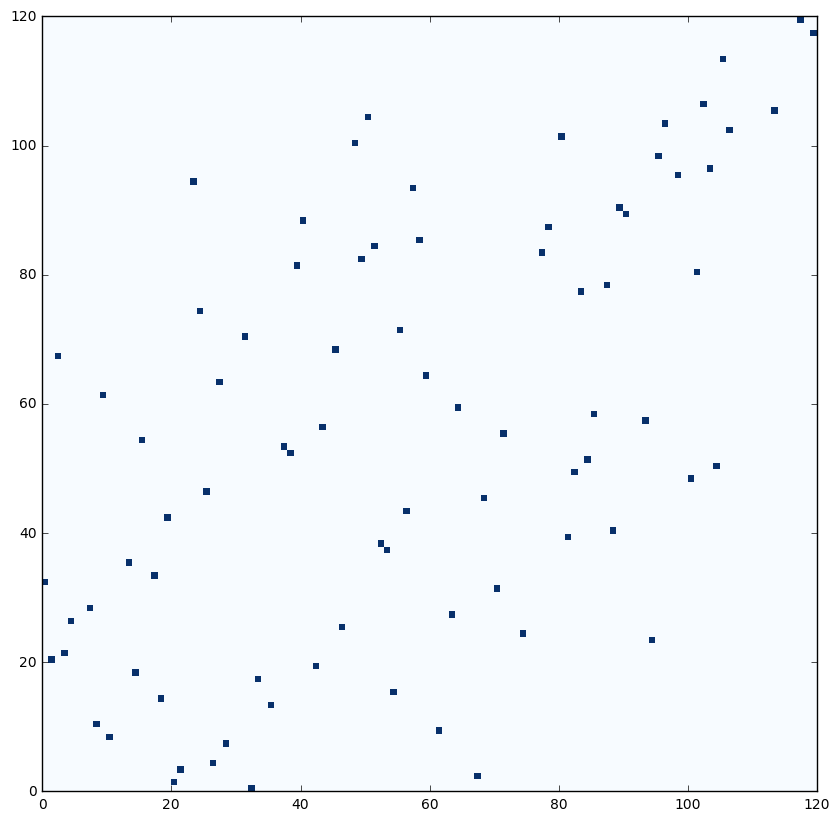

In [6]:
plot_matrix(A-Ag)

In [7]:
from sklearn.cluster import KMeans
def kmeans(eigen_vector, unames, n_clusters):
    kmean = KMeans(n_clusters=n_clusters)
    clusters = kmean.fit_predict(eigen_vector)
    cluster_uname = list(zip(clusters, uname))
    cluster_uname.sort(key=lambda x:x[0])
    # print(cluster_uname)
    return clusters

def sort_by_cluster(matrix, clusters):
    sorted_mat = list(zip(clusters, matrix))
    sorted_mat.sort(key=lambda x:x[0])
    _,sorted_mat = list(zip(*sorted_mat))
    
    sorted_mat = list(zip(clusters, np.array(sorted_mat).T))
    sorted_mat.sort(key=lambda x:x[0])
    sorted_clusters,sorted_mat = zip(*sorted_mat)
    return np.array(sorted_mat).T, sorted_clusters

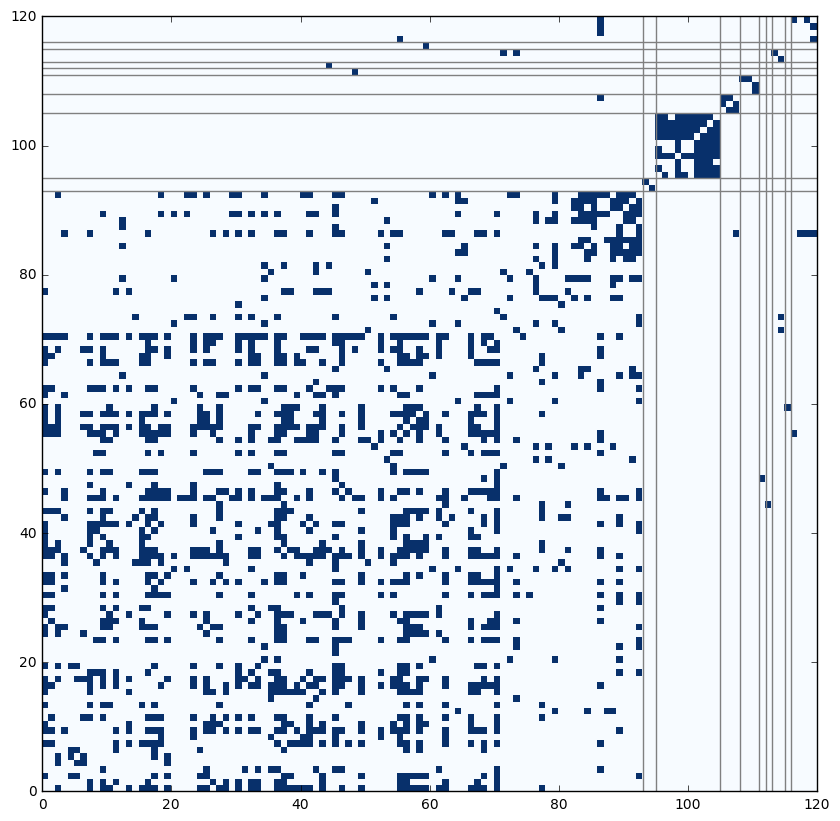

In [8]:
clusters = kmeans(H, uname, K)
plot_matrix(*sort_by_cluster(Ag, clusters))

In [41]:
Ag = deepcopy(A)
count = 0
last_trace = 1000000
while True:
    # update H
    D = np.eye(N) * Ag.sum(axis=0)
    L = D - Ag
    L_rw = np.dot(np.linalg.inv(D) , L)
    λ, H = scipy.linalg.eigh(L_rw,eigvals=(lo,hi))
    trace = np.trace(np.matrix(H).T * np.matrix(Ag) * np.matrix(H)) #<  then break ??
    print(trace)

    if (last_trace <= trace) and (count > 10):
        break
        print(Ag)
    last_trace = trace
    count += 1
    
    Ag = deepcopy(A)
    list_countᵢ = A.sum(axis=0) - m    
    exclude_edge = np.ones(Ag.shape)
    X = []
    pₑ = np.array([[Ag[i,j] * np.dot(H[i] - H[j], H[i] - H[j]) \
                    - np.dot(np.abs(λ)**0.5 * H[i], np.abs(λ)**0.5 * H[i]) \
                    - np.dot(np.abs(λ)**0.5 * H[i], np.abs(λ)**0.5 * H[j]) for i in range(N)] for j in range(N)])

    while pₑ.max() > 0:
        pₑ = np.array([[exclude_edge[i,j] * Ag[i,j] * np.dot(H[i] - H[j], H[i] - H[j]) for i in range(N)] for j in range(N)])
        i,j = np.unravel_index(pₑ.argmax(), pₑ.shape)
        #print(pₑ.max())
        #print(list_countᵢ[i], list_countᵢ[j])
        if (list_countᵢ[i]>0) and (list_countᵢ[j]>0):
            X.append((i,j))
            list_countᵢ[i] = -1
            list_countᵢ[j] = -1
            Ag[i,j] = 0
            Ag[j,i] = 0
            #print(X)
            #print(len(X))
            if len(X) > θ:
                break
        else:
            exclude_edge[i,j] = 0
            exclude_edge[j,i] = 0
    

56.9626328448
53.4852329225
53.9395465749
53.9546124617
53.9546124617
53.9546124617
53.9546124617
53.9546124617
53.9546124617
53.9546124617
53.9546124617
53.9546124617


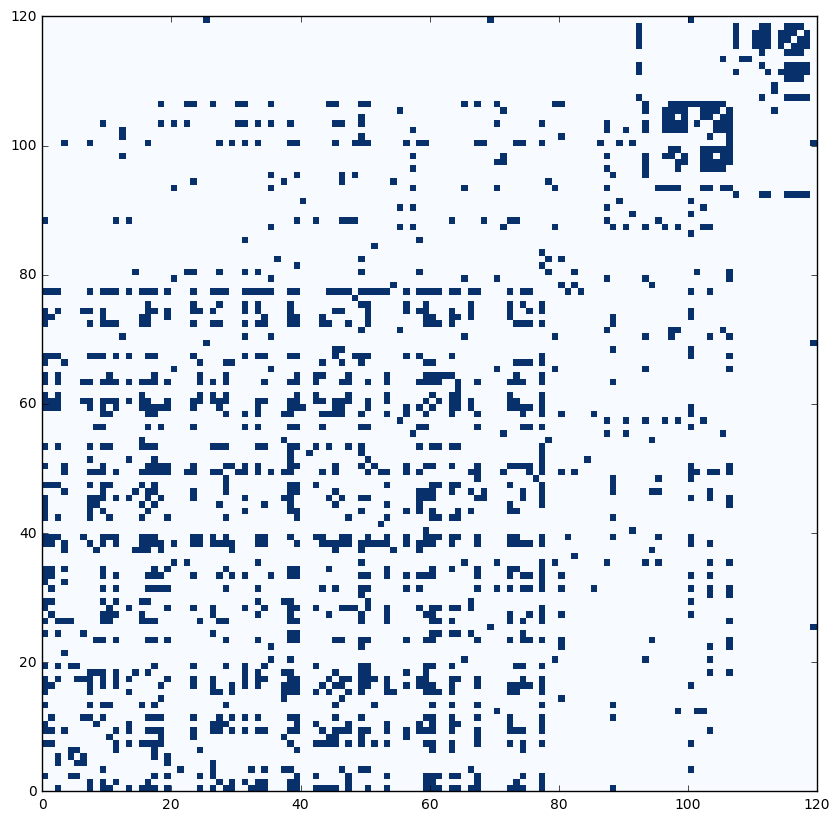

In [42]:
plot_matrix(Ag)

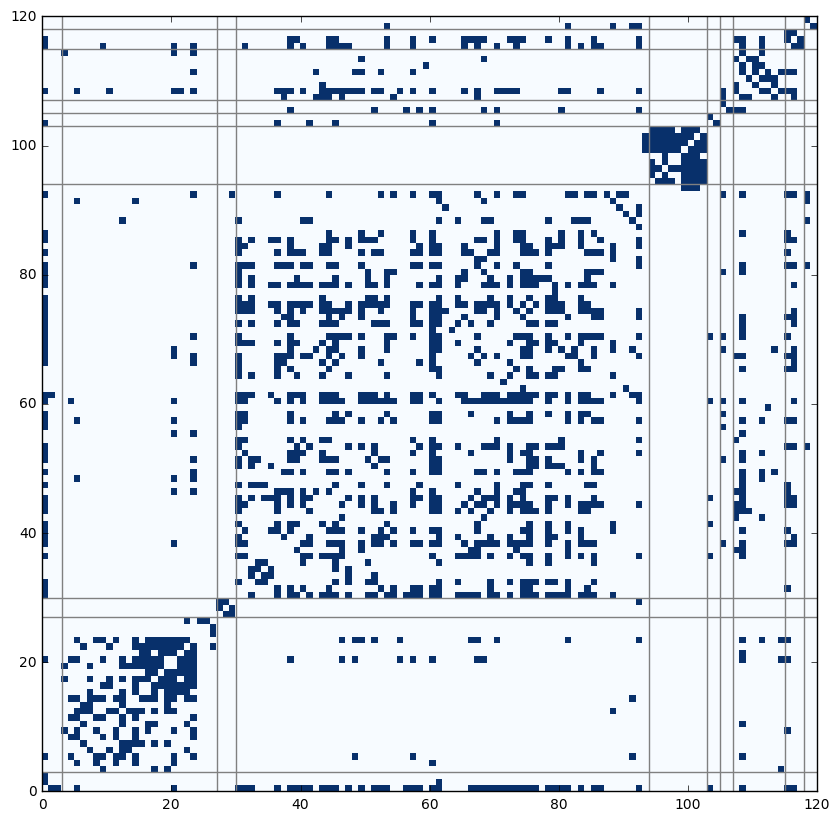

In [43]:
clusters = kmeans(H, uname, K)
plot_matrix(*sort_by_cluster(Ag, clusters))